In [1]:
%matplotlib widget
from astropy import constants as cst
from astropy import units as u
from scipy import interpolate
import numpy as np
import pylab as plt
#%qtconsole

# Flux from the star

## Relevant info

On simbad: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=proxima+cen&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id


1Jy = 10^-26 W/m2/Hz

## Open PHOENIX model

In [2]:
wave = np.loadtxt('WAVE_PHOENIX-ACES-AGSS-COND-2011_t0.txt')
wave /= 10 # Angstrom to nm

sp = np.loadtxt('lte03000-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes_t0.txt') # [J/s/cm2/cm]
#sp *= u.J / (u.s * u.cm**2 * u.cm)


Text(0.5, 0, 'Wavelength [nm]')

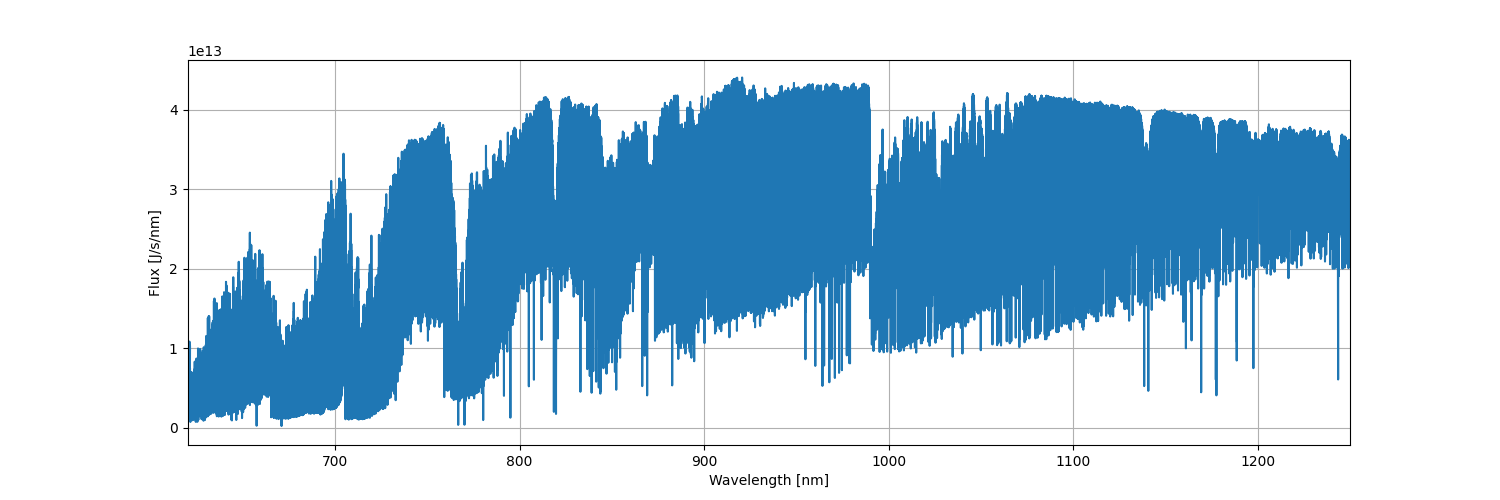

In [3]:
plt.figure(figsize=(15,5))
plt.plot(wave, sp)
plt.grid(True)
plt.xlim([620,1250])
plt.ylabel('Flux [J/s/nm]')
plt.xlabel('Wavelength [nm]')

## Convert flux to photons per second on Earth

In [4]:
#
#   f=f/1e7                                      # J/s/cm2/cm
#   f=f/(6.626e-34*2.99792458e8/wave*1e10)       # photons/s/cm2/cm
#   f=f*1e4                                      # photons/s/m2/cm
#   f=f*4*pi*1.0652e8**2                         # photons/s/cm (total emitted flux, using PHOENIX radius which gives a decent (10%) match to Proxima empirical luminosity of 5.93e30 erg/s)
#   f=f/4/pi/(1.30*3.0857e16)**2                 # photons/s/m2/cm (flux received at Earth)
#
h = cst.h.value # 
c = cst.c.value # m/s

hNu = h*c/wave/1e-9
VLT_surface = np.pi*(8.1/2)**2  # 50m2

proxCenRadius = 1.0652e8 # [m]
starSurface   = 4*np.pi*proxCenRadius**2 # [m2]

spPh = sp/1e14
spPh /= hNu         # ph/s/cm2/cm
spPh *= 1e4         # photons/s/m2/cm
spPh *= starSurface # photons/s/cm, total emitted flux
spPh /= 4*np.pi*(1.30*3.0857e16)**2 # photons/s/m2/cm, received flux on Earth

spPh = spPh*VLT_surface  # ph/s/nm
ind0 = np.argmin(np.abs(wave-600))


## Define bands and integration functions

In [5]:
RbandLim = np.array([600, 800])
IbandLim = np.array([850,1000])
JbandLim = np.array([1050, 1350])
KbandLim = np.array([1950, 2450])
RISTRETTO = np.array([620,840])

In [6]:
def integrateFlux(lbd, flux, lbdMin, lbdMax):
    ind0 = np.argmin(np.abs(lbd-lbdMin))
    ind1 = np.argmin(np.abs(lbd-lbdMax))

    fluxInt = np.trapz(flux[ind0:ind1], lbd[ind0:ind1])
    
    return fluxInt

## Interpolate data on the spectrum grid

In [7]:
minWave = 500
maxWave = 2000

# Atmosphere Transmission

In [8]:
atm0 = np.loadtxt('transdata_0.5_1_mic')
atm1 = np.loadtxt('transdata_1_5_mic')

atm0[:,0] = 1e7/atm0[:,0] # nm
atm1[:,0] = 1e7/atm1[:,0]

# Sort by increasing wavelength
s0 = np.argsort(atm0[:,0])
atm0 = atm0[s0,:]

s1 = np.argsort(atm1[:,0])
atm1 = atm1[s1,:]



Text(0, 0.5, 'Atm. transmission')

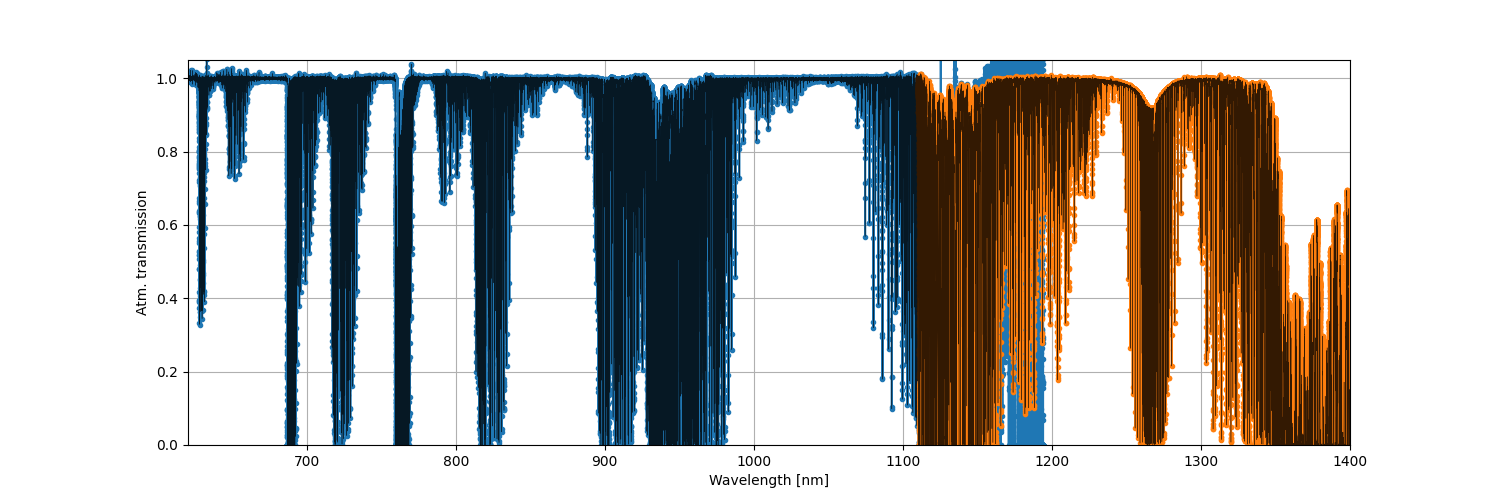

In [9]:
atm0[atm0<0]=0
atm1[atm1<0]=0

joinWave = np.min(atm1[:,0])
ind0 = np.argmin(np.abs(atm0[:,0]-joinWave))
ind1 = np.argmin(np.abs(atm1[:,0]-joinWave))

waveAtm = np.append(atm0[:ind0,0], atm1[ind1:,0])
absAtm  = np.append(atm0[:ind0,1], atm1[ind1:,1])


plt.figure(figsize=(15,5))
plt.plot(atm0[:,0], atm0[:,1], '.-')
plt.plot(atm1[:,0], atm1[:,1], '.-')
plt.plot(waveAtm, absAtm, lw=0.3, alpha=0.8, c='k')
plt.ylim([0,1.05])
plt.xlim([620,1400])
plt.grid(True)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Atm. transmission')

In [10]:
# Cut data to proper range in atmospheric data
ind0 = np.argmin(np.abs(waveAtm-minWave+1))
ind1 = np.argmin(np.abs(waveAtm-maxWave-1))
waveAtm = waveAtm[ind0:ind1]
absAtm  = absAtm[ind0:ind1]

# Cut data to proper range in stellar data
ind0 = np.argmin(np.abs(wave-minWave))
ind1 = np.argmin(np.abs(wave-maxWave))
wave = wave[ind0:ind1]
spPh = spPh[ind0:ind1]



# Interpolate atmospheric data onto stellar ones
F = interpolate.interp1d(waveAtm,absAtm, kind='linear', fill_value=0)
absAtm = F(wave)

Text(0.5, 1.0, 'Proxima Cen flux at VLT surface [ph/s/nm]')

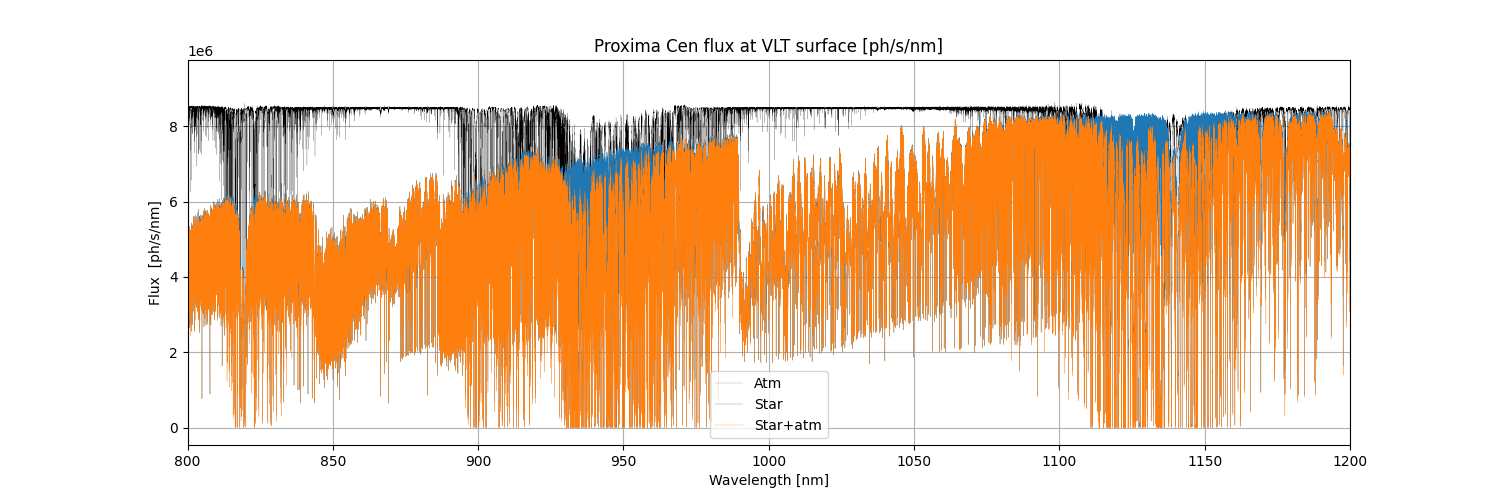

In [11]:
plt.figure(figsize=(15,5))
plt.plot(wave, absAtm*np.max(spPh), lw=0.1, c='k', label='Atm')
plt.plot(wave, spPh, label='Star', lw=0.2)
plt.plot(wave, absAtm*spPh, label='Star+atm', lw=0.2)
plt.grid(True)
plt.legend(loc='best')
plt.xlim([800,1200])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux  [ph/s/nm]')
plt.title('Proxima Cen flux at VLT surface [ph/s/nm]')


* Average transmission of the atmosphere on the RISTRETTO band (Zenith)

In [12]:
t_atm = integrateFlux(wave,absAtm,RISTRETTO[0],RISTRETTO[1])/integrateFlux(wave,np.ones(absAtm.shape),RISTRETTO[0],RISTRETTO[1])
print(f"Average Transmission of atmosphere on the RISTRETTO science band at the Zenith : {t_atm*100:0.1f} %")

Average Transmission of atmosphere on the RISTRETTO science band at the Zenith : 96.6 %


# WFS - CRed one QE

In [13]:
QE_CRED = np.zeros(wave.shape)+1e-9
ind0 = np.argmin(np.abs(wave-700))
QE_CRED[ind0:] = 0.6
ind0 = np.argmin(np.abs(wave-1000))
ind1 = np.argmin(np.abs(wave-1500))
QE_CRED[ind0:ind1] = 0.6 + 0.1*(wave[ind0:ind1]-wave[ind0])/(wave[ind1]-wave[ind0])
QE_CRED[ind1:] = 0.7

Text(0.5, 0, 'Wavelength [nm]')

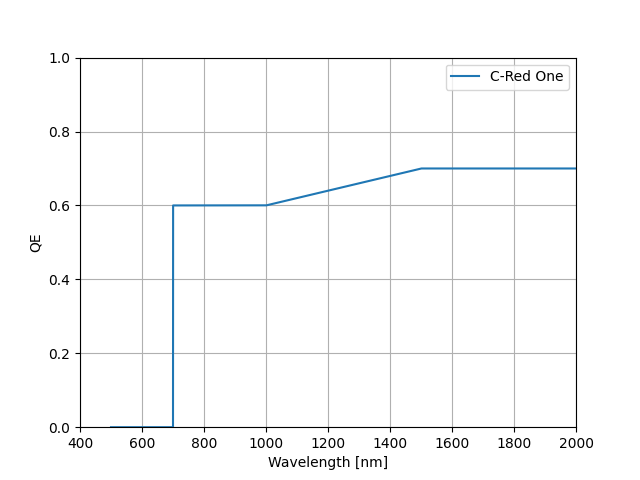

In [14]:
plt.figure()
plt.plot(wave, QE_CRED, label='C-Red One')
plt.grid(True)
plt.xlim([400,2000])
plt.ylim([0.,1])
plt.xlabel('Wavelength [nm]')
plt.ylabel('QE')
plt.legend(loc='best')
plt.xlabel('Wavelength [nm]')

# Total instrument Transmission

## Telescope : Aluminum mirror coating

Transmission of the Telescope in the spectrograph band : 61.2 %


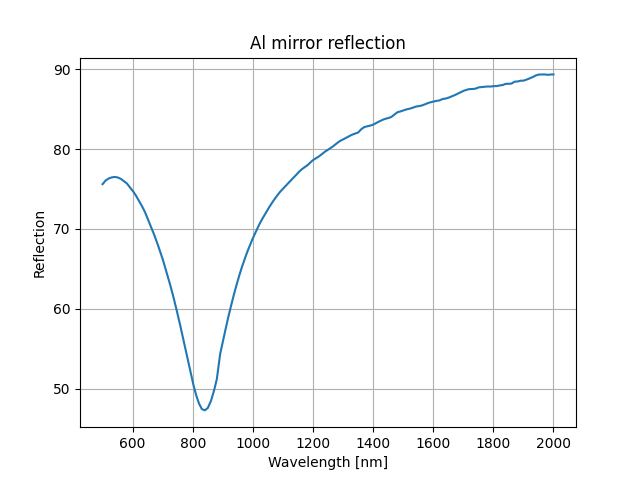

In [15]:
al_coating = np.loadtxt('al_mirror_AOI_12deg.txt')
alWave = al_coating[:,0]*1000 # [nm]
alR    = al_coating[:,1]/100 # [%]

# Cut data to proper range in atmospheric data
ind0 = np.argmin(np.abs(alWave-minWave))-1
ind1 = np.argmin(np.abs(alWave-maxWave))+1
alWave = alWave[ind0:ind1]
alR    = alR[ind0:ind1]


# Interpolate atmospheric data onto stellar ones
F = interpolate.interp1d(alWave,alR, kind='linear', fill_value=0)
alR = F(wave)

tVLT = alR**3

plt.figure()
plt.plot(wave, tVLT*100)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflection')
plt.title('Al mirror reflection')
plt.grid(True)


tVLT_spectro = tVLT[(wave>620) & (wave < 840)].mean()
print(f"Transmission of the Telescope in the spectrograph band : {tVLT_spectro*100:0.1f} %")

## Front-End Optical transmission

5th March 2024 design

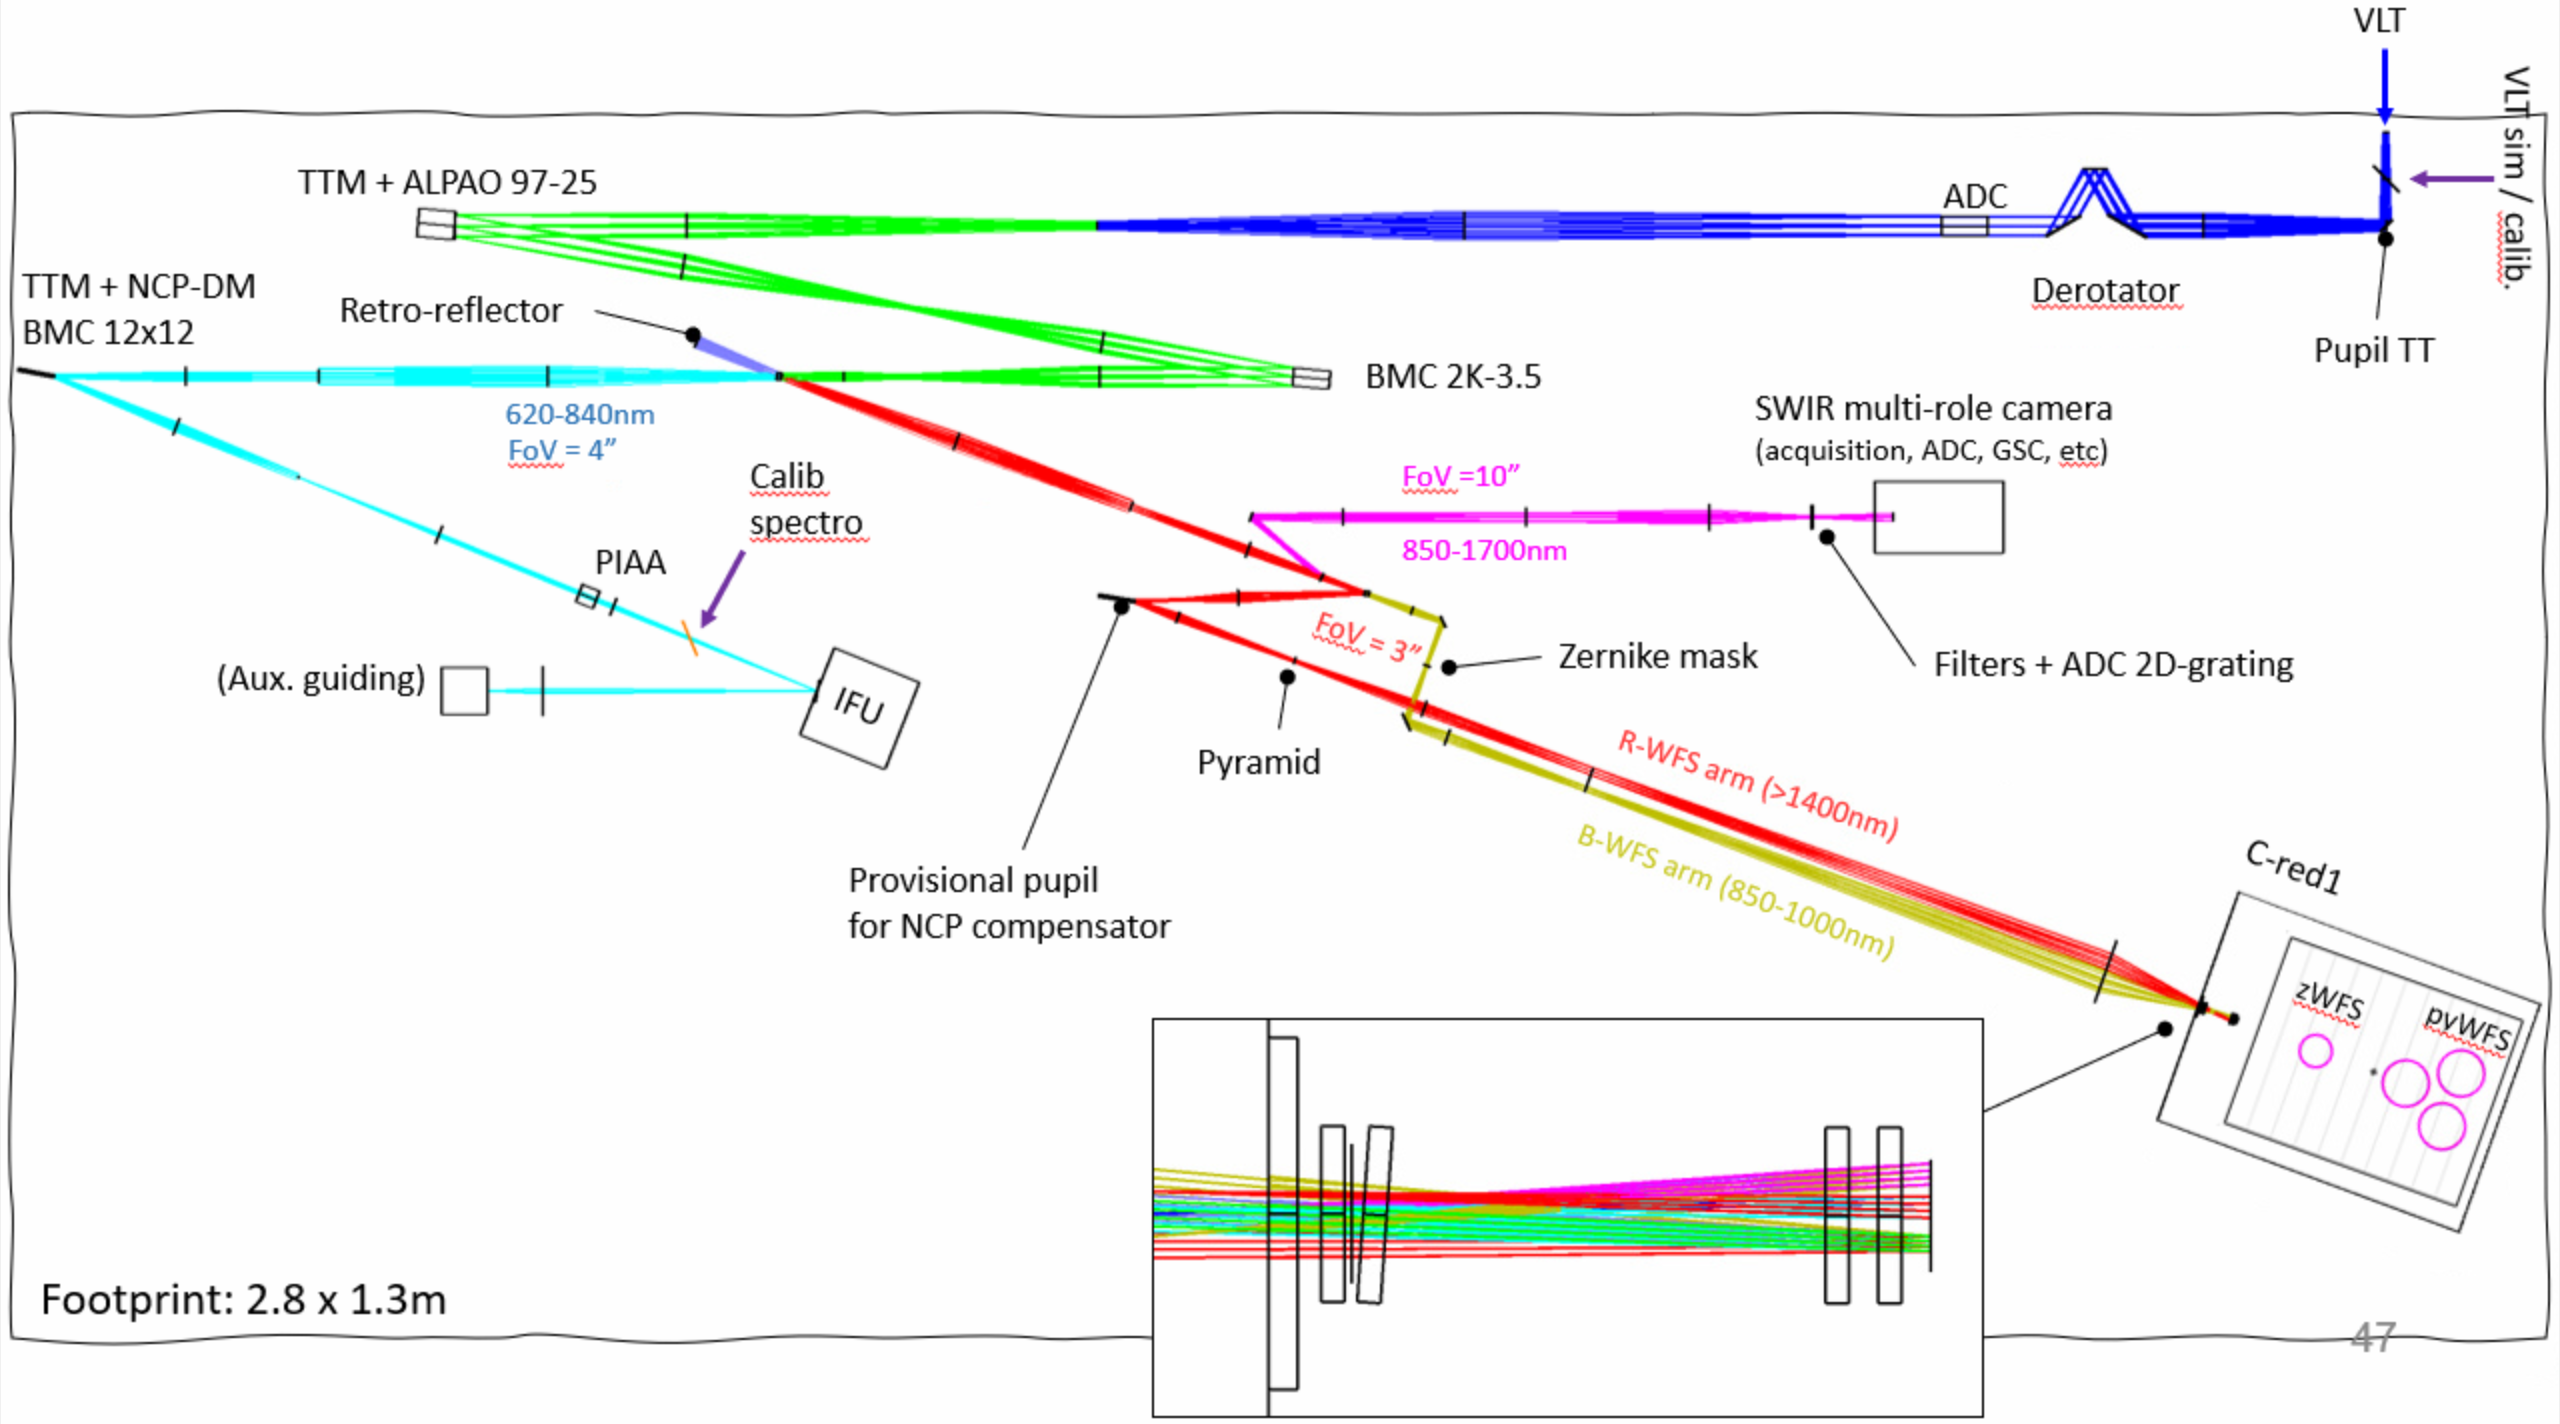


In [16]:
rpAg    = 0.97
tLens   = 0.995**2 # Lens & Windows
tADC    = 0.995**4 * 0.995**2 # 4 AR coatings 2 glass / glass interface 
tDichro = 0.98 * 0.995

NlensCP    = 3 # including 2 surfaces for ADC
NmirrorCP  = 6+6 # including K-mirror
NlensSci   = 2 # Including PIAA+Pupil mask
NmirrorSci = 4
NlensAO    = 12 # Including 5 windows in Cred1 + Fourier masks
NmirrorAO  = 1  # + 2 dichro

tCP      = rpAg**NmirrorCP * tLens**NlensCP
tScience = tDichro * rpAg**NmirrorSci * tLens**NlensSci
tAO      = tDichro**2 * tLens**NlensAO * rpAg**NmirrorAO

print("Transmission for reflective design:")
print(f"Transmission science: {tCP*tScience*100:0.1f} %")
print(f"Transmission XAO:     {tCP*tAO*100:0.1f} %")
print(f" --- Potential gain of 5-7 lenses if use of pupil-pupil conjugates wuthout intermediate focii")

Transmission for reflective design:
Transmission science: 57.0 %
Transmission XAO:     55.1 %
 --- Potential gain of 5-7 lenses if use of pupil-pupil conjugates wuthout intermediate focii


In [17]:
rpAg    = 0.97
tLens   = 0.995**2 # Lens & Windows
tADC    = 0.995**4 * 0.995**2 # 4 AR coatings 2 glass / glass interface 
tDichro = 0.98 * 0.995

NlensCP    = 9 # including 2 surfaces for ADC
NmirrorCP  = 6 # including K-mirror
NlensSci   = 7 # Including PIAA+Pupil mask
NmirrorSci = 1 
NlensAO    = 12 # Including 5 windows in Cred1 + Fourier masks
NmirrorAO  = 1  # + 2 dichro

tCP      = rpAg**NmirrorCP * tLens**NlensCP
tScience = tDichro * rpAg**NmirrorSci * tLens**NlensSci
tAO      = tDichro**2 * tLens**NlensAO * rpAg**NmirrorAO

print("--- Transmission for refractive design ---")
print(f"Transmission science: {tCP*tScience*100:0.1f} %")
print(f"Transmission XAO:     {tCP*tAO*100:0.1f} %")
print(f" --- Potential gain of 5-7 lenses if use of pupil-pupil conjugates wuthout intermediate focii")


--- Transmission for refractive design ---
Transmission science: 67.1 %
Transmission XAO:     62.2 %
 --- Potential gain of 5-7 lenses if use of pupil-pupil conjugates wuthout intermediate focii


## AO Performances

In [33]:
Strehl = 0.7 # Strehl (best case scenario)

### AO & acqusition photon budget

In [34]:
def integrateFlux(wave0, wave1, wave, spectrum):
    ind0 = np.argmin(np.abs(wave-wave0))
    ind1 = np.argmin(np.abs(wave-wave1))        
    return np.sum((spectrum[1:]*np.diff(wave))[ind0:ind1])

In [35]:
fluxAO   = spPh*absAtm*alR**3*tCP*tAO # ph/s/nm


wave0 = 850
wave1 = 1000
fluxBWFS = integrateFlux(wave0,wave1, wave, fluxAO)

NsubapLin = 60
Nsubap    = NsubapLin**2*np.pi/4

print('Flux on B-WFS between %4.0f and %4.0fnm:'%(wave0, wave1))
print('   Total:  %.1e ph/ms'%(fluxBWFS/1000))
print('   Useful: %.0f ph/ms/subap'%(fluxBWFS/Nsubap/1000))
print('')


NsubapLin = 60
Nsubap    = NsubapLin**2*np.pi/4
wave0 = 1400
wave1 = 1500

fluxRWFS = integrateFlux(wave0,wave1, wave, fluxAO)
print('Flux on R-WFS between %4.0f and %4.0fnm:'%(wave0, wave1))
print('   Total:  %.1e ph/ms'%(fluxRWFS/1000))
print('   Useful: %.0f ph/ms/subap'%(fluxRWFS/Nsubap/1000))

Flux on B-WFS between  850 and 1000nm:
   Total:  2.8e+05 ph/ms
   Useful: 98 ph/ms/subap

Flux on R-WFS between 1400 and 1500nm:
   Total:  2.0e+05 ph/ms
   Useful: 70 ph/ms/subap


In [37]:
EEdiffLim = 0.8 # Energy in the core of the diffraction limited PSF 
fluxAcq = spPh*absAtm*alR**3*tCP*tAO*EEdiffLim*Strehl # ph/s/nm, energy in PSF core

wave0 = 850
wave1 = 1000
fluxAcq_ = integrateFlux(wave0,wave1, wave, fluxAcq)
print('Flux on Acquisition camera between %4.0f and %4.0fnm: %.1e ph/s'%(wave0, wave1, fluxAcq_))

wave0 = 500
wave1 = 600
fluxAcq_ = integrateFlux(wave0, wave1, wave, fluxAcq)
print('Flux on Acquisition camera between %4.0f and %4.0fnm: %.1e ph/s'%(wave0, wave1, fluxAcq_))



Flux on Acquisition camera between  850 and 1000nm: 1.6e+08 ph/s
Flux on Acquisition camera between  500 and  600nm: 1.2e+07 ph/s


## Coronagraph perf

* Will contain the coupling performance of the PIAA+IFU

In [38]:
tPIAA = 0.7 #np.ones(7) (Best case scenario)

## Fiber link

* Single Mode Fiber S-630-HP raw performances : Attenuation <10 db/km @ 630 nm

In [39]:
lFL = 30 # m
tS630HP = 10**(-10*lFL/1000/10)
print(f"Raw Fiber Transmission : {tS630HP*100:0.1f} %")

Raw Fiber Transmission : 93.3 %


* Fresnel lens on the 3d Printed Lens, with no coatings

In [40]:
n_resin3d = 1.54
t3dlens = 1-((1-n_resin3d)/(1+n_resin3d))**2
print(f"3d printed Lens Transmission : {t3dlens*100:0.1f} %")

3d printed Lens Transmission : 95.5 %


* Total transmission of the Fiber Link :

In [41]:
t_FL = tS630HP*t3dlens
print(f"Fiber Link Efficiency : {t_FL*100:0.1f} %")

Fiber Link Efficiency : 89.1 %


## Spectrograph

* Optical transmission of the spectrograph at the maximum of the blaze

Text(0.5, 1.0, 'Optical Transmission of the Spectrograph')

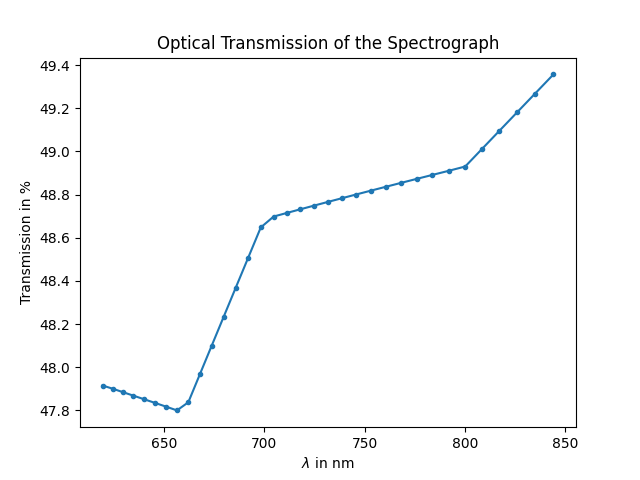

In [42]:
tOPspectro = np.loadtxt("GlobalOptic_Transmission_no_QE.txt")

plt.figure()
plt.plot(tOPspectro[:,0]*1000,tOPspectro[:,1]*100,".-")
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Transmission in %")
plt.title("Optical Transmission of the Spectrograph")

* Quantum efficiency of the spectrograph

Text(0.5, 1.0, 'Quantum efficiency E2V 4K DD Astro-multi-2')

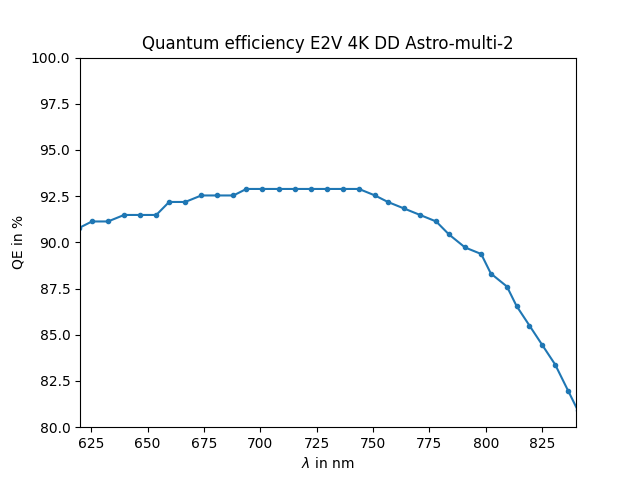

In [43]:
QESpectro = np.loadtxt("E2V_astro_multi2.dat",skiprows=1,delimiter=",")

plt.figure()
plt.plot(QESpectro[:,0],QESpectro[:,1],".-")
plt.xlabel("$\lambda$ in nm")
plt.ylabel("QE in %")
plt.xlim(620,840)
plt.ylim(80,100)
plt.title("Quantum efficiency E2V 4K DD Astro-multi-2")

* Average Efficiency of the spectrograph including QE at the Blaze maximum 

In [44]:
t_spectro = tOPspectro[:,1].mean()*QESpectro[:,1][(QESpectro[:,0]<840)&(QESpectro[:,0]>620)].mean() / 100
print(f"Average Efficiency of the spectrograph : {t_spectro*100:0.1f} %")

Average Efficiency of the spectrograph : 43.9 %


## Total instrument Transmission transmission

In [50]:
print(tCP, tScience, t_FL, t_spectro)

0.7611072502554319 0.8817470617587028 0.8910729885469441 0.43941290233061153


In [51]:
t_instru = tCP * tScience * t_FL * t_spectro
print(f"Total instrument Transmission without consider AO and fiber coupling : {t_instru*100:0.1f}%")

Total instrument Transmission without consider AO and fiber coupling : 26.3%


In [52]:
print(f"Total instrument transmision wo AO and fiber coupling, /w atm. & telescope: {t_instru * t_atm * tVLT_spectro *100:0.1f} %")

Total instrument transmision wo AO and fiber coupling, /w atm. & telescope: 15.5 %


In [53]:
t_instru = tCP * tScience * Strehl * tPIAA * t_FL * t_spectro
print(f"Total instrument Transmission without Telescope nor atmosphere : {t_instru*100:0.1f}%")

Total instrument Transmission without Telescope nor atmosphere : 12.9%


In [54]:
print(f"Total instrument Transmision all included : {t_instru * t_atm * tVLT_spectro *100:0.1f} %")

Total instrument Transmision all included : 7.6 %
